### Company XYZ is an Online Travel Agent, such as Expedia, Booking.com, etc. They store their data in JSON files. Each row in the json shows all different cities which have been searched for by a user within the same session (as well as some other info about the user). That is, if I go to company XYZ site and look for hotels in NY and SF within the same session, the corresponding JSON row will show my user id, some basic info about me and the two cities.
### You are given the following tasks:
#### (1) There was a bug in the code and one country didn't get logged. It just shows up as an empty field (""). Can you guess which country was that? How?
#### (2) For each city, find the most likely city to be also searched for within the same session.
#### (3) Travel sites are browsed by two kinds of users. Users who are actually planning a trip and users who just dream about a vacation. The first ones have obviously a much higher purchasing intent. Users planning a trip often search for cities close to each other, while users who search for cities far away from each other are often just dreaming about a vacation. That is, a user searching for LA, SF and Las Vegas in the same session is much more likely to book a hotel than a user searching for NY, Paris, Kuala Lumpur (makes sense, right?). Based on this idea, come up with an algorithm that clusters sessions into two groups: high intent and low intent. Explain all assumptions you make along the way.

### Load the package would be used

In [1]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", 10)
pd.set_option("display.width", 350)
import json
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


### Read in the data set

#### Define a function

In [2]:
def json_parse(dat):
    """Defina a function to parse json data"""
    session_id = []
    unix_timestamp = []
    cities = []
    user_id = [] 
    joining_date = []
    country = []
    
    for i in dat:
        session_id.append(i["session_id"][0])
        unix_timestamp.append(i["unix_timestamp"][0])
        cities.append(i["cities"][0])
        user_id.append(i["user"][0][0]["user_id"])
        joining_date.append(i["user"][0][0]["joining_date"])
        country.append(i["user"][0][0]["country"])
        
    ##### Create pandas dataframe
    pd_dat = pd.DataFrame(data = {"session_id": session_id, "timestamp": unix_timestamp, "cities": cities, 
                                  "user_id": user_id, "joining_date": joining_date, "country": country},
                          columns = ["session_id", "timestamp", "cities", "user_id", "joining_date", "country"])
    return pd_dat

#### Load dataset

In [3]:
with open("../Datasets/city_search.json", "r") as f:
    json_dat = json.load(f)

dat = json_parse(dat = json_dat)
dat["timestamp"] = pd.to_datetime(dat["timestamp"], unit = "s")
dat["joining_date"] = pd.to_datetime(dat["joining_date"], format = "%Y-%m-%d")

### Look into dataset

In [4]:
print(dat.shape)
print(dat.info)
print(list(dat.columns))
print(len(dat["session_id"]) == len(pd.unique(dat["session_id"])))
dat.head()

(20022, 6)
<bound method DataFrame.info of           session_id           timestamp                                        cities  user_id joining_date country
0      X061RFWB06K9V 2015-09-17 15:28:28                        New York NY, Newark NJ     2024   2015-03-22      UK
1      5AZ2X2A9BHH5U 2015-09-04 08:06:31  New York NY, Jersey City NJ, Philadelphia PA     2853   2015-03-28      DE
2      SHTB4IYAX4PX6 2015-08-29 10:18:10                                San Antonio TX    10958   2015-03-06      UK
3      JBRB8MZGTX3M4 2015-03-25 07:21:03                                   Edmonton AB     7693   2015-03-12      IT
4      YJCMPURC2FL9C 2015-05-02 09:31:07                        Phoenix AZ, Houston TX     7506   2015-02-28      UK
...              ...                 ...                                           ...      ...          ...     ...
20017  17WJGZOEFEI4W 2015-05-02 05:40:04                       Chicago IL, Montreal QC     4360   2015-03-21        
20018  9HCZDQMGU5Z2G 

,session_id,timestamp,cities,user_id,joining_date,country
0,X061RFWB06K9V,2015-09-17 15:28:28,"New York NY, Newark NJ",2024,2015-03-22,UK
1,5AZ2X2A9BHH5U,2015-09-04 08:06:31,"New York NY, Jersey City NJ, Philadelphia PA",2853,2015-03-28,DE
2,SHTB4IYAX4PX6,2015-08-29 10:18:10,San Antonio TX,10958,2015-03-06,UK
3,JBRB8MZGTX3M4,2015-03-25 07:21:03,Edmonton AB,7693,2015-03-12,IT
4,YJCMPURC2FL9C,2015-05-02 09:31:07,"Phoenix AZ, Houston TX",7506,2015-02-28,UK


#### (1) There was a bug in the code and one country didn't get logged. It just shows up as an empty field (""). Can you guess which country was that? How?

In [5]:
dat["hour"] = dat["timestamp"].apply(lambda x: x.hour)
grp_country = dat[["country", "timestamp"]].groupby("country").count().reset_index().rename(columns = {"timestamp": "count"})
grp_country

,country,count
0,,2820
1,DE,3638
2,ES,1953
3,FR,2298
4,IT,1882
5,UK,3555
6,US,3876


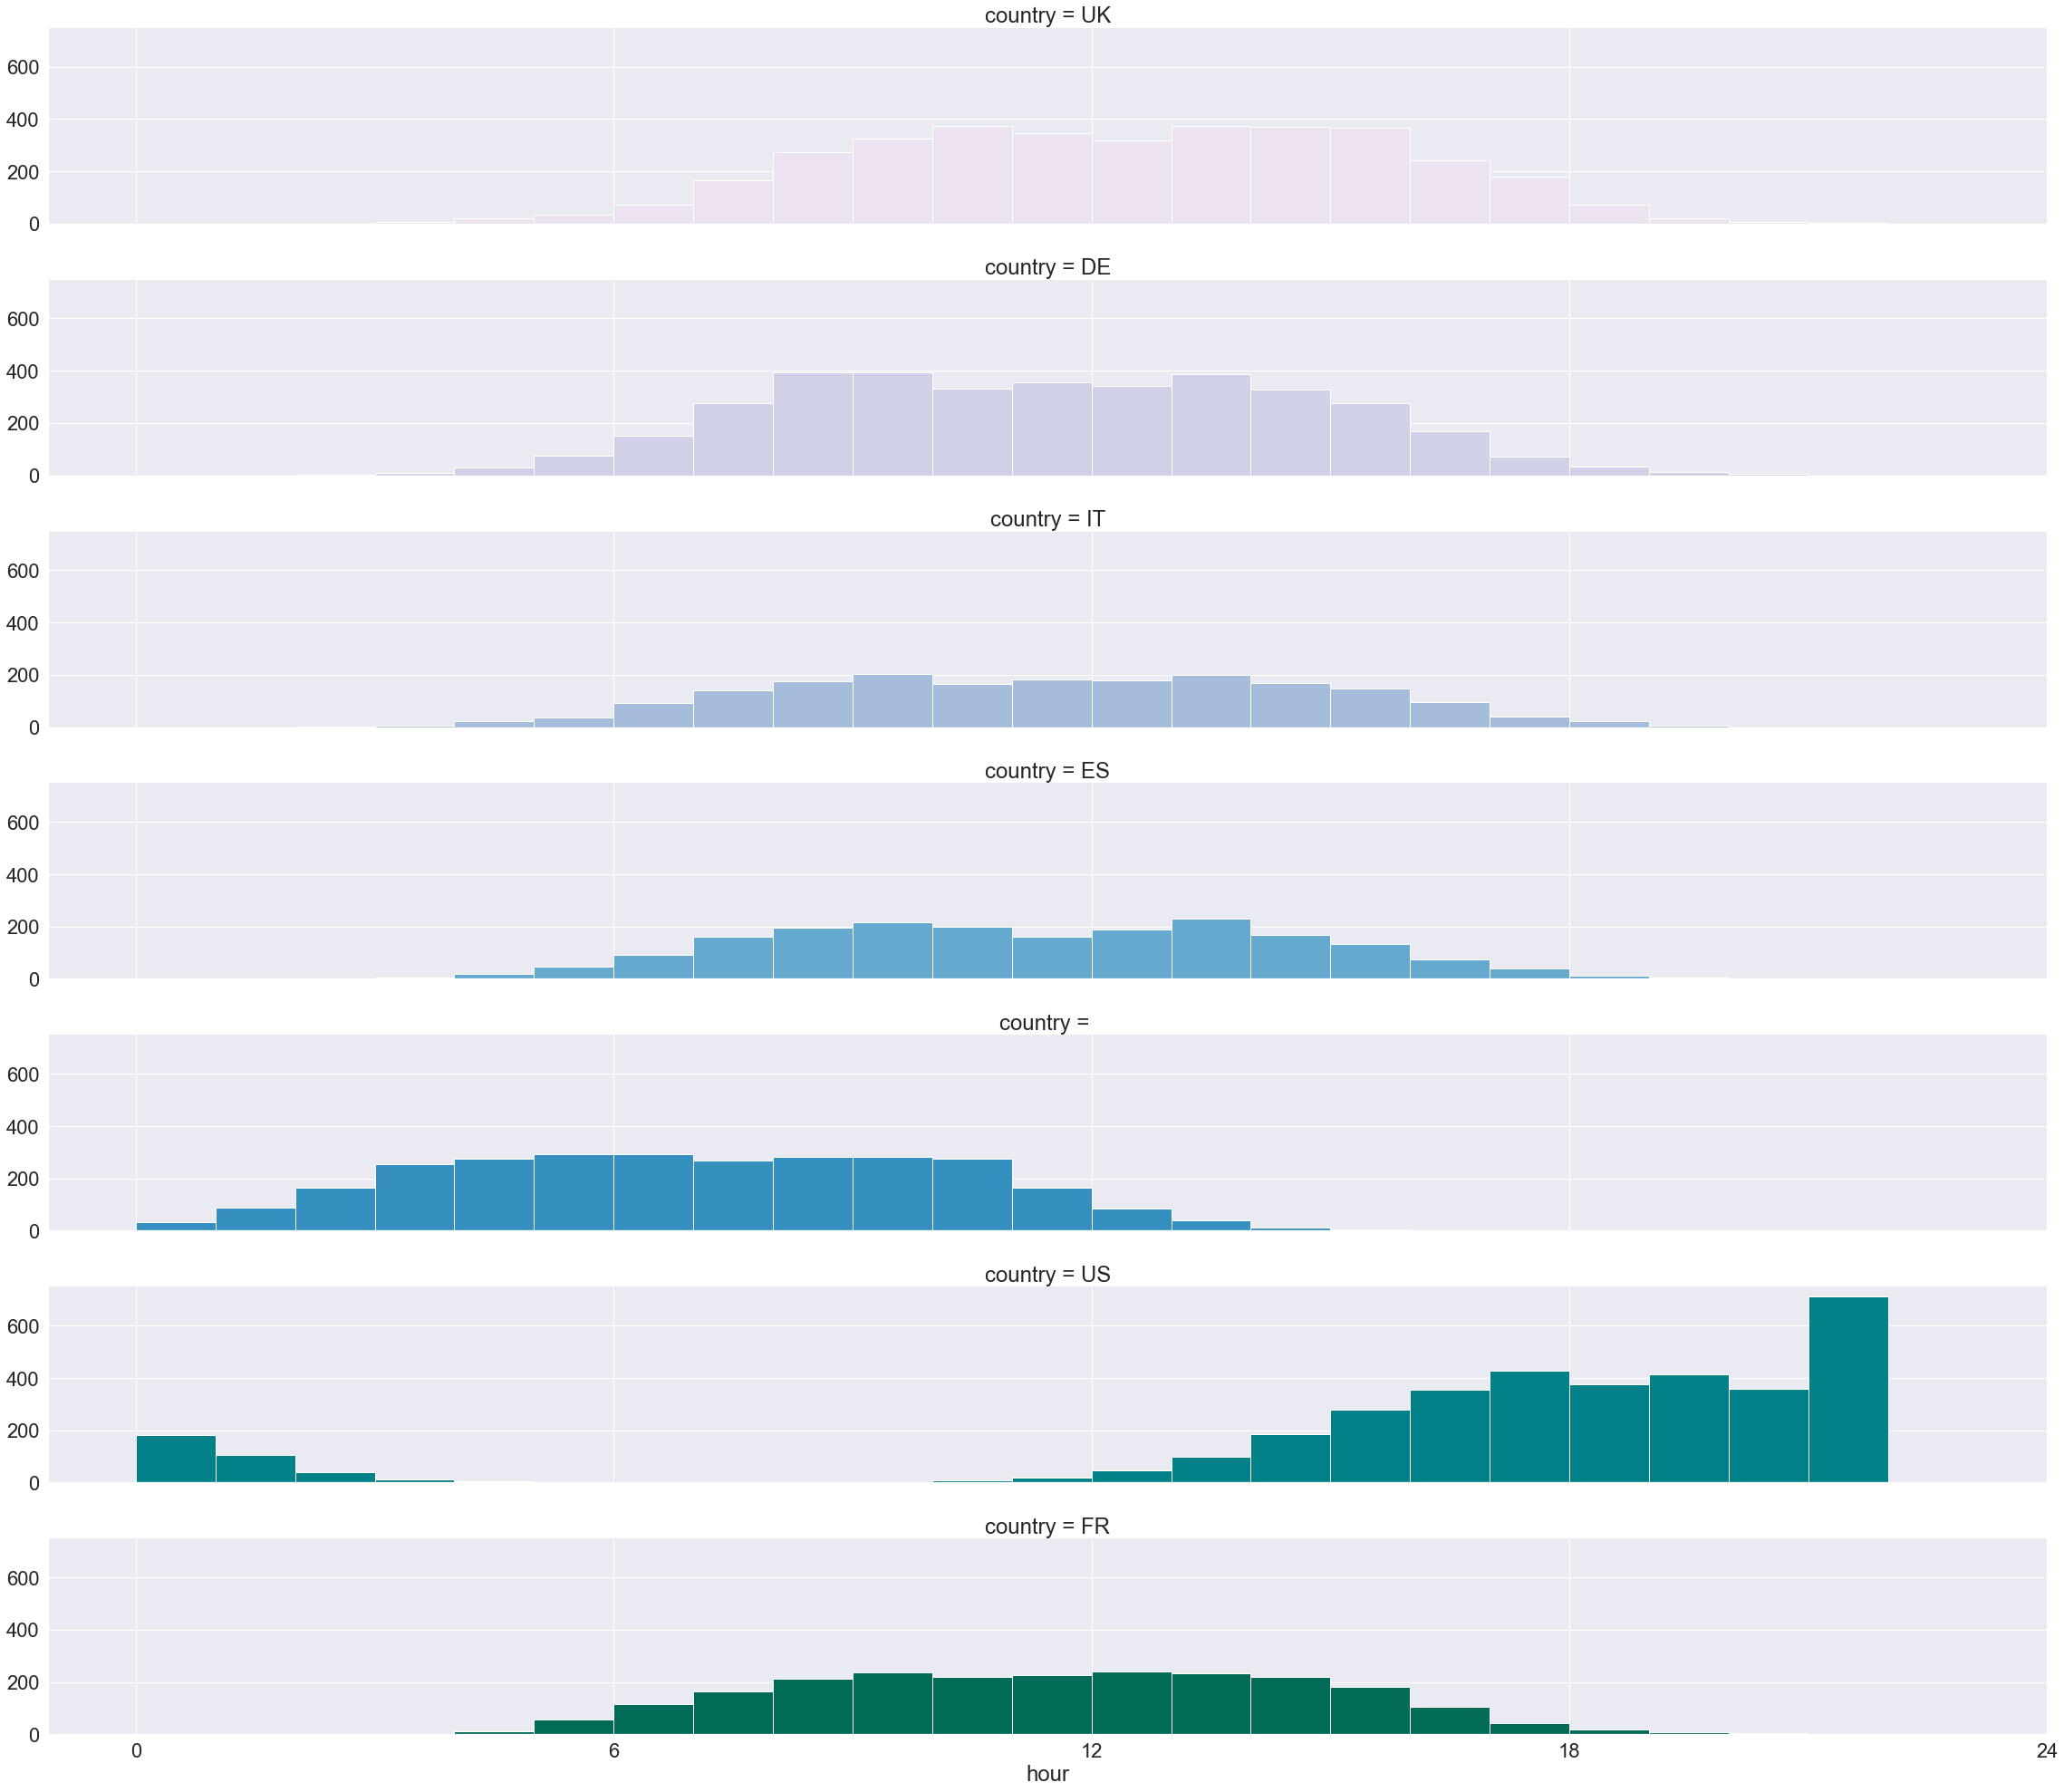

In [6]:
sns.set(font_scale = 2)
time_by_country = sns.FacetGrid(dat[["country", "hour"]], row = "country", hue = "country", palette = "PuBuGn",
                                height = 4, aspect = 8).map(plt.hist, "hour", bins = np.arange(0, 23, 1)).set(xticks = [0, 6, 12, 18, 24], yticks = [0, 200, 400, 600])

Missing should be some countries in Asia.

#### (2) For each city, find the most likely city to be also searched for within the same session.

##### Step 1: Create the similarity matrix (Here, we define the similarity as the occasions of search together)

In [7]:
city_split = dat["cities"].str.split(", ", n = 10, expand = True)
city_split["session_id"] = dat["session_id"]
city_split.head()

,0,1,2,3,4,...,7,8,9,10,session_id
0,New York NY,Newark NJ,None,None,None,...,None,None,None,None,X061RFWB06K9V
1,New York NY,Jersey City NJ,Philadelphia PA,None,None,...,None,None,None,None,5AZ2X2A9BHH5U
2,San Antonio TX,None,None,None,None,...,None,None,None,None,SHTB4IYAX4PX6
3,Edmonton AB,None,None,None,None,...,None,None,None,None,JBRB8MZGTX3M4
4,Phoenix AZ,Houston TX,None,None,None,...,None,None,None,None,YJCMPURC2FL9C


In [8]:
city_long = pd.melt(city_split, id_vars = ["session_id"], value_vars = city_split.columns[0:11])
city_long = city_long.dropna()
city_long.head()
city_long[city_long["session_id"] == "X061RFWB06K9V"]

,session_id,variable,value
0,X061RFWB06K9V,0,New York NY
20022,X061RFWB06K9V,1,Newark NJ


In [9]:
city_wide = pd.crosstab(city_long.session_id, city_long.value, margins = False).reset_index()
city_wide.head()

value,session_id,Anaheim CA,Arlington TX,Atlanta GA,Austin TX,...,Victoria BC,Virginia Beach VA,WASHINGTON DC,Wichita KS,Windsor ON
0,0004TZ56GY6S7,0,0,0,0,...,0,0,0,0,0
1,004M08GLQ7ZXH,0,0,0,0,...,0,0,0,0,0
2,007O320DQ7AXT,0,0,0,0,...,0,0,0,0,0
3,007UIISVZJOW5,0,0,0,0,...,0,0,0,0,0
4,008ZL2D1PLC4O,0,0,0,0,...,0,0,0,0,0


In [10]:
cities = pd.Series(city_wide.columns)[1:]
len(cities)

89

In [11]:
city_matrix = city_wide.drop(columns = "session_id")

In [12]:
city_pair = np.zeros((len(cities), len(cities)))

for i in range(len(city_matrix)):
    search = city_matrix.iloc[i][city_matrix.iloc[i] != 0]
    if len(search) == 1:
        continue
    for j in range(len(search)):
        index1 = cities[cities == search.index[j]].index - 1
        for k in range(j + 1, len(search)):
            index2 = cities[cities == search.index[k]].index - 1
            city_pair[index1, index2] += 1
            city_pair[index2, index1] += 1

In [13]:
df_similarity = pd.DataFrame(city_pair, index = cities, columns = cities)
df_similarity.head()

value,Anaheim CA,Arlington TX,Atlanta GA,Austin TX,Bakersfield CA,...,Victoria BC,Virginia Beach VA,WASHINGTON DC,Wichita KS,Windsor ON
value,,,,,,,,,,,
Anaheim CA,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0
Arlington TX,0.0,0.0,0.0,34.0,0.0,...,0.0,0.0,0.0,0.0,0.0
Atlanta GA,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
Austin TX,0.0,34.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
Bakersfield CA,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0


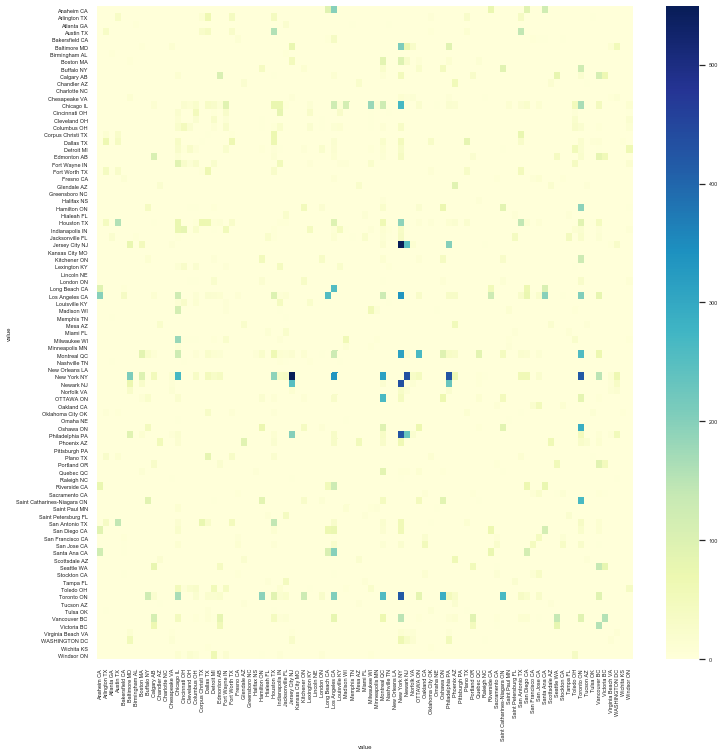

In [14]:
# visualization
sns.set(font_scale = 0.5)
plt.figure(figsize = [12, 12])
sns.heatmap(df_similarity, cmap = "YlGnBu")

In [15]:
similar_city = df_similarity.apply(np.argmax, axis = 0).reset_index()
similar_city = similar_city.rename(columns = {"index": "city", 0: 'most similar'})
similar_city

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return bound(*args, **kwds)


,value,most similar
0,Anaheim CA,Los Angeles CA
1,Arlington TX,Dallas TX
2,Atlanta GA,Jacksonville FL
3,Austin TX,Houston TX
4,Bakersfield CA,Los Angeles CA
...,...,...
84,Victoria BC,Vancouver BC
85,Virginia Beach VA,New York NY
86,WASHINGTON DC,New York NY
87,Wichita KS,Oklahoma City OK


In [16]:
city_matrix.head()

value,Anaheim CA,Arlington TX,Atlanta GA,Austin TX,Bakersfield CA,...,Victoria BC,Virginia Beach VA,WASHINGTON DC,Wichita KS,Windsor ON
0,0,0,0,0,0,...,0,0,0,0,0
1,0,0,0,0,0,...,0,0,0,0,0
2,0,0,0,0,0,...,0,0,0,0,0
3,0,0,0,0,0,...,0,0,0,0,0
4,0,0,0,0,0,...,0,0,0,0,0


#### (3) Travel sites are browsed by two kinds of users. Users who are actually planning a trip and users who just dream about a vacation. The first ones have obviously a much higher purchasing intent. Users planning a trip often search for cities close to each other, while users who search for cities far away from each other are often just dreaming about a vacation. That is, a user searching for LA, SF and Las Vegas in the same session is much more likely to book a hotel than a user searching for NY, Paris, Kuala Lumpur (makes sense, right?). Based on this idea, come up with an algorithm that clusters sessions into two groups: high intent and low intent. Explain all assumptions you make along the way.

In [17]:
intension = np.zeros(len(city_matrix))
scores = 0

for i in range(len(city_matrix)):
    search = city_matrix.iloc[i][city_matrix.iloc[i] != 0]
    if len(search) == 1:
        continue
    else:
        for j in range(len(search)):
            index1 = cities[cities == search.index[j]].index - 1
            for k in range(j + 1, len(search)):
                index2 = cities[cities == search.index[k]].index - 1
                scores += df_similarity.iloc[index1.values, index2.values].values
    intension[i] = scores
    scores = 0

In [18]:
city_wide["intension"] = intension
city_wide["length"] = city_matrix.sum(axis = 1)
city_cluster = city_wide[["intension", "length"]]
print(city_cluster.describe())
city_cluster.head()

value     intension        length
count  20022.000000  20022.000000
mean     135.706173      1.648986
std      272.342103      0.874272
min        0.000000      1.000000
25%        0.000000      1.000000
50%        0.000000      1.000000
75%      174.000000      2.000000
max     3069.000000     11.000000


value,intension,length
0,60.0,2
1,0.0,1
2,0.0,1
3,0.0,1
4,270.0,2


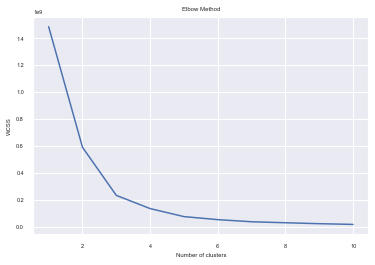

In [19]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = "k-means++", max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(city_cluster.dropna())
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title("Elbow Method")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show()

In [20]:
##### # of clusters as requested
kmeans2 = KMeans(n_clusters = 2, random_state = 0).fit(city_cluster.dropna())       
kmeans2.cluster_centers_

array([[903.67446809,   3.42695035],
       [ 77.52675693,   1.51429185]])

In [21]:
##### # of clusters from the statistical perspective
kmeans3 = KMeans(n_clusters = 3, random_state = 0).fit(city_cluster.dropna())       
kmeans3.cluster_centers_

array([[1.35955882e+03, 3.93566176e+00],
       [3.04692166e+01, 1.35853612e+00],
       [4.00629580e+02, 2.53891415e+00]])